In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [2]:
positive_affect = pd.read_json('dataset/EMA/response/PAM/PAM_u00.json')

In [3]:
positive_affect

,picture_idx,resp_time
0,7,2013-03-24 08:45:48
1,11,2013-03-24 20:15:56
2,7,2013-03-24 08:40:30
3,8,2013-03-24 08:45:42
4,7,2013-03-26 02:21:15
...,...,...
385,7,2013-06-06 05:35:39
386,7,2013-06-07 19:46:18
387,10,2013-06-26 23:09:43
388,7,2013-06-26 23:18:04


In [4]:
def combine_daily_emas(ema_name): 
    """
    input: ema_name -- name of the ema we're looking at
    output: dataframe containing the data from the desired ema compiled for all uids
    """
    # list of all the desired ema's 
    all_emas = glob.glob('dataset/EMA/response/' + ema_name + '/' + ema_name +'_*.json')
    # index to start the uid
    uid_start = len('dataset/EMA/response/' + ema_name + '/' + ema_name +'_')
    # this is where we'll compile the data
    total_ema_data = pd.DataFrame()
    # loops through all the ema data
    for ema in all_emas: 
        # the uid is the three characters starting at uid_start index
        uid = ema[uid_start:uid_start + 3]
        # read the data
        ema_data = pd.read_json(ema)
        # keep track of day and day of week
        try:
            ema_data['doy'] = ema_data['resp_time'].dt.dayofyear 
            ema_data['day of week'] = ema_data['resp_time'].dt.dayofweek
            ema_data = ema_data.groupby('doy').mean()
            ema_data['day'] = ema_data.index
        except:
            # in this case there is an empty dataframe for this uid
            continue
        
        # keep track of uids
        ema_data['uid'] = uid
        
        # compile the data
        total_ema_data = total_ema_data.append(ema_data)

    return total_ema_data    

In [5]:
def merge_EMA(EMA_list): 
    """
    input: EMA_list -- contains a list of tuples, each tuple containing the name of an EMA and the name of a desired column
    in that EMA.
    output: a dataframe combining all those EMA's for every user. 
    """
    initialized = False
    for tup in EMA_list: 
        ema = tup[0]
        col = tup[1]
        ema_for_all_students = combine_daily_emas(ema)
        
        relevant_columns = ema_for_all_students[[col, 'day', 'day of week', 'uid']]
        
        if initialized is False: 
            initialized = True
            overall_merge = relevant_columns
        else: 
            overall_merge = overall_merge.merge(relevant_columns, on = ['day', 'day of week', 'uid'], how = 'inner')
    
    return overall_merge

In [6]:
def most_responded_emas():
    """
    output:  dictionary of (ema name: number of responses) where each key is an ema and the value is the number 
    of days it was responded to 
    """
    ema_lengths = {}
    for file in glob.glob('dataset/EMA/response/*'): 
        ema = file[len('dataset/EMA/response/'):]
        total_emas = combine_daily_emas(ema)
        # number of days the ema was responded to 
        ema_lengths[ema] = total_emas.shape[0]
        # this will give us the number of students responding to the ema on each day
        if ema_lengths[ema] > 500: 
            daily_emas = total_emas.groupby('day').count()
    
            plt.bar(daily_emas.index, daily_emas['uid'])
            plt.xlabel('day')
            plt.ylabel('number of students who responded')
            plt.title(ema + ' responses over time')
            plt.show()
        
    return ema_lengths

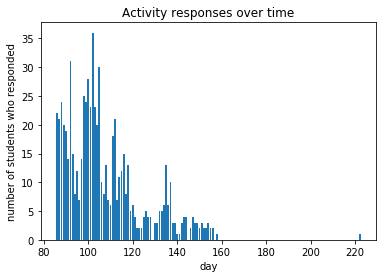

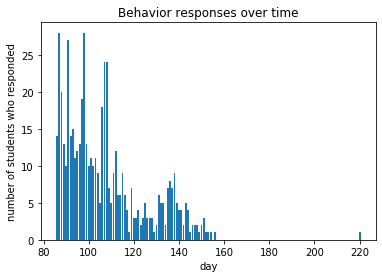

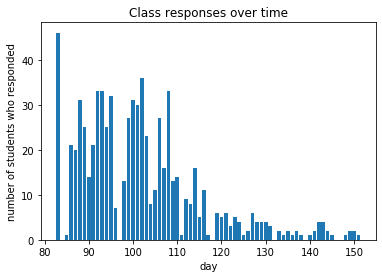

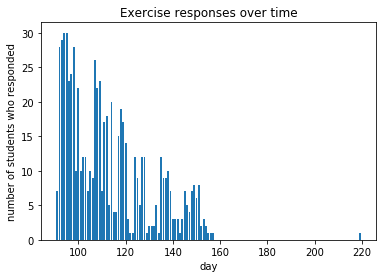

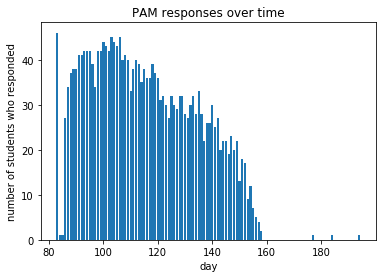

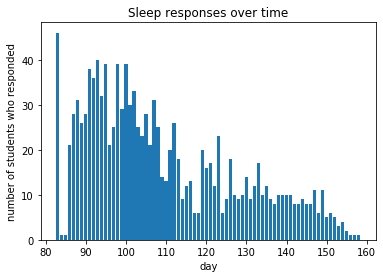

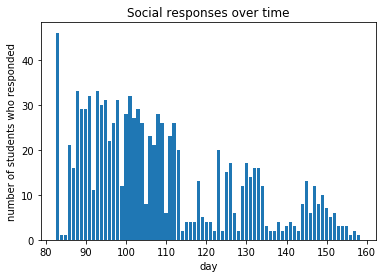

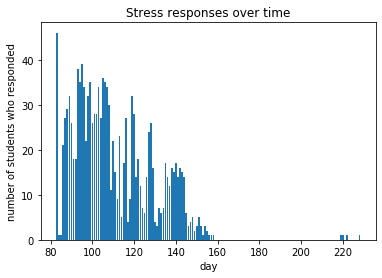

{'Activity': 703,
 "Administration's response": 33,
 'Behavior': 554,
 'Boston Bombing': 14,
 'Cancelled Classes': 34,
 'Class': 724,
 'Class 2': 88,
 'Comment': 403,
 'Dartmouth now': 27,
 'Dimensions': 25,
 'Dimensions protestors': 24,
 'Dining Halls': 194,
 'Events': 218,
 'Exercise': 686,
 'Green Key 1': 29,
 'Green Key 2': 25,
 'Lab': 134,
 'Mood': 213,
 'Mood 1': 230,
 'Mood 2': 339,
 'PAM': 2296,
 'QR_Code': 0,
 'Sleep': 1251,
 'Social': 1031,
 'Stress': 1292,
 'Study Spaces': 286}

In [7]:
most_responded_emas()

In [8]:
mood_and_PAM = merge_EMA([('PAM', 'picture_idx'), ('stress', 'level'), ('social', 'number')])

In [9]:
mood_and_PAM = mood_and_PAM.dropna()
mood_and_PAM['weekend'] = mood_and_PAM['day of week'] > 4
mood_and_PAM_u00 = mood_and_PAM[mood_and_PAM['uid'] == 'u01']
mood_and_PAM_u00

,picture_idx,day,day of week,uid,level,number,weekend
22,7.500000,86,2.0,u01,4.0,3.333333,False
23,12.750000,88,4.0,u01,1.0,4.000000,False
24,9.600000,89,5.0,u01,3.0,3.000000,True
25,11.333333,90,6.0,u01,1.0,4.000000,True
26,11.500000,93,2.0,u01,1.0,2.000000,False
27,10.333333,95,4.0,u01,4.0,4.000000,False
28,10.500000,96,5.0,u01,4.5,4.000000,True
29,13.666667,97,6.0,u01,1.0,3.000000,True
30,9.400000,100,2.0,u01,1.5,3.000000,False
31,8.000000,102,4.0,u01,1.0,2.000000,False


In [10]:
from sklearn.decomposition import PCA
def plot_pca(EMA_df, feature_columns, target_column):
    """
    given input features plots a principal component analysis (first two components)
    """
    # keep the first two principal components of the data
    features = EMA_df[feature_columns].values
    pca = PCA(n_components=2)
    pg_transformed = pca.fit_transform(features)
    pg_df = pd.DataFrame(data = pg_transformed, columns = ['PC_1', 'PC_2'])
    
    # print relevant results
    print("features: ", feature_columns)
    print("component 1 weights: ", pca.components_[0])
    print("component 2 weights: ", pca.components_[1])
    print("variance explained: ", pca.explained_variance_ratio_)
    
    # make a plot of the principal components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == True], 
               pg_transformed[:,1][EMA_df[target_column] == True], 
               label = target_column ,marker ='o')
    
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == False], 
               pg_transformed[:,1][EMA_df[target_column] == False], 
               label = 'not {}'.format(target_column), marker = 'x')
    
    plt.legend(loc='upper right')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    return pg_transformed

In [11]:
def convert_stress(level):
    """
    converts input stress level from the scale above into a more usable scale with 1 being feeling great 
    and 5 being stressed out.
    """
    # little stress = 3/5 stressed
    if level == 1: 
        return 3
    # definitely stressed = 4/5
    if level == 2:
        return 4
    # stressed out = 5/5
    if level == 3:
        return 5
    # feeling good = 2/5
    if level == 4: 
        return 2
    # feeling great = 1/5 
    if level == 5:
        return 1
    else:
        return 0

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

def random_forest_importance(features, target, features_names, plot): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
    given input features and targets (labels), a random forest model is created to find the importance of each feature to 
    the target. Plots these outcomes. 
    """
    n_features = features.shape[1]
    # just from some guess and check, it seems that using 500 estimators greatly reduces the random element of the 
    # classifier
    model = RandomForestClassifier(n_estimators = 500)
    model.fit(features, target)
    if plot is True: 
        print('average cross validation score: {:.2f}'.format(cross_val_score(model, features, target, cv = 5).mean()))
        plot_feature_importance(n_features, features_names, model.feature_importances_)
    return model.feature_importances_

In [13]:
def plot_feature_importance(n_features, features_names, feature_importance): 
    """
    input: n_features: number of features
           features_names: names of features
           feature_importance: the importance of each feature
    makes a bar plot showing the importance of each feature. 
    """
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')

In [14]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def svc_importance(features, target, features_names, plot):
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
    given input features and targets (labels), a LinearSVC model is created to find the importance of each feature to 
    the target. Plots these outcomes. 
    """
    
    clf = make_pipeline(StandardScaler(), LinearSVC())
    
    clf.fit(features, target)
        
    return clf.named_steps['linearsvc'].coef_
    

In [15]:
def process_stress_ema(uid): 
    """
    input: uid for which we want to process the stress EMA
    """
    stress = pd.read_json('dataset/EMA/response/stress/Stress_' + uid + '.json')
    stress = stress[['location', 'resp_time', 'level']]
    stress = stress.dropna()
    stress['level'] = stress['level'].apply(convert_stress)
    stress['day'] = stress['resp_time'].dt.dayofyear
    stress = stress.groupby('day').mean()
    # since stress levels are discrete, we want to take the nearest overall stress level for the day 
    stress = stress.apply(lambda x: round(x))
    stress['doy'] = stress.index
    
    return stress

In [16]:
def process_stress_ema_remove_null(uid): 
    """
    input: uid for which we want to process the stress EMA
    """
    stress = pd.read_json('dataset/EMA/response/stress/Stress_' + uid + '.json')
    try: 
        stress['level'] = stress['level'].where(np.isfinite, stress.null)
    except: 
        pass
    
    stress['level'] = pd.to_numeric(stress.level, errors='coerce')
    
    stress = stress[['resp_time', 'level']]
    stress = stress.dropna()
    
    stress['level'] = stress['level'].apply(convert_stress)
    stress['day'] = stress['resp_time'].dt.dayofyear
    stress = stress.groupby('day').mean()
    # since stress levels are discrete, we want to take the nearest overall stress level for the day 
    stress = stress.apply(lambda x: round(x))
    stress['doy'] = stress.index
    
    return stress

In [17]:
process_stress_ema('u57').head()

,level,doy
day,,
86,2.0,86
87,2.0,87
88,2.0,88
90,1.0,90
92,3.0,92


In [18]:
process_stress_ema_remove_null('u57').head()

,level,doy
day,,
86,2.0,86
87,2.0,87
88,2.0,88
90,1.0,90
92,3.0,92


In [19]:
def stress_feature_importance(uid, plot = False): 
    """
    ranks the feature importance of five different sensors: activity inference, conversation duration, 
    bluetooth colocations, darkness, and location variance based on how important they are at predicting stress for a 
    given day. 
    """
    stress = process_stress_ema_remove_null(uid)
    
    # compiling features (sensors) and grouping them all by day. 
    activity = pd.read_csv('dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    conversation = pd.read_csv('dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation = conversation.groupby('day').sum()
    
    bluetooth = pd.read_csv('dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    
    
    features_list = [(daily_activity, ' activity inference'), (conversation, 'convo duration'), 
                     (darkness, 'dark duration'), (bluetooth, 'number colocations'), 
                     (wifi_locations, 'unique locations')]
    
    # merge all the sensors with stress to create a feature dataframe 
    data = stress
    for feat in features_list: 
        data = data.merge(feat[0][[feat[1]]], 
                                left_on = 'doy', right_on = 'day', how = 'inner')
        
    #print('dataframe size: {}'.format(data.shape))
    
    # take only large data, with a size of 20 or greater
    if data.shape[0] < 20: 
        return None
    
    features_names = [' activity inference', 'convo duration', 'dark duration',
                     'number colocations', 'unique locations']
    # create numpy arrays to represent features and targets
    features = data[features_names].values
    
    target = data['level'].values
    
    # this is where we calculate feature importance
    feat_import = random_forest_importance(features, target, features_names, plot)
    
    #svc_feat_import = svc_importance(features, target, features_names)
    
    return feat_import, features_names

average cross validation score: 0.57


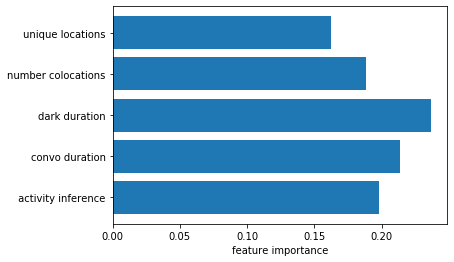

In [20]:
test = stress_feature_importance('u10', True)

In [21]:
def compile_feat_imports(): 
    """
    returns the overall feature imports of stress files
    """
    stress_files = glob.glob('dataset/EMA/response/stress/Stress_*.json')
    uid_start = len('dataset/EMA/response/stress/Stress_')
    counter = 1
    # loops through all the files and averages the feature importance lists
    for file in stress_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        
        try:
            importance = stress_feature_importance(uid, False)
        except: 
            # in the case where the above fails, there was no data in the user's ema file, so we skip that user. 
            continue 
        
        if importance is None:
            continue 
        
        if counter == 1: 
            uid_feature_importance = stress_feature_importance(uid, False)[0]
        else: 
            uid_feature_importance = (uid_feature_importance*(counter - 1) +
                                          stress_feature_importance(uid, False)[0])/counter
        counter += 1
        
    return uid_feature_importance

In [22]:
compile_feat_imports()

array([0.2039467 , 0.20478954, 0.20208907, 0.21484792, 0.17432677])

As you can see, there isn't much variation overall with regard to feature importance, but variation still exists within each user, so we'll look more into that. 

In [23]:
def rank_sensors(): 
    """
    loops through all the stress files and returns a dictionary mapping each user id to a list containing the ranking 
    of its sensor features from greatest to least
    """
    stress_files = glob.glob('dataset/EMA/response/stress/Stress_*.json')
    uid_start = len('dataset/EMA/response/stress/Stress_')
    counter = 1
    # this dictionary will keep track of the most important sensor for each user. 
    most_imp_dict = {}
    # loops through all the files and averages the feature importance lists
    for file in stress_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        # find feature importance
        try:
            res = stress_feature_importance(uid, False)
        except:
            print(uid)
            continue
        if res is None: 
            continue
        feat_imp = res[0]
        sensors = res[1]
        # reorder the features here
        most_imp_dict[uid] = order(feat_imp, sensors)
        
    return most_imp_dict

In [24]:
def order(feat_imp, sensors): 
    """
    inputs: feat_imp -- array containing the importance of each sensor
            sensors -- the sensor corresponding to each element in the array
    """
    # sort from least to greatest
    sorty = np.sort(feat_imp)
    
    # make a dictionary where the key is the feature importance and the value is the sensor 
    # im making the assumption that no two keys will be the same since there are not many sensors and 
    # accuracy is to many decimals. 
    sorty_dict = {}
    for i in range(len(feat_imp)): 
        sorty_dict[feat_imp[i]] = sensors[i]
    
    # make a sorted sensors list using the dictionary
    sorted_sensors = []
    for elem in sorty: 
        sorted_sensors.append(sorty_dict[elem])
    
    # reverse so the order is most important to least important sensor
    sorted_sensors.reverse()
    
    return sorted_sensors

In [25]:
rankings = rank_sensors()

u13


In [26]:
def plot_ranking(sensor_rankings): 
    """
    input: sensor_rankings -- dictionary containing uids mapping to ranking sensor importance
    plots histograms displaying the count of the users for which sensors are the highest or lowest ranked
    """
    rank_df = pd.DataFrame(rankings)
    # this dataframe will have rankings as columns and uids as each row
    rank_df = rank_df.transpose()
    
    # make the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7)) 
    # first subplot
    ax1.hist(rank_df[0])
    ax1.set_ylabel('number of users')
    ax1.set_title('most important sensor for predicting daily stress (by user)')
    
    # second subplot
    ax2.hist(rank_df[4])
    ax2.set_ylabel('number of users')
    ax2.xaxis.label.set_fontsize(15)
    ax2.set_title('least important sensor for predicting daily stress (by user)')
    
    for label in ax1.get_xticklabels() + ax2.get_xticklabels():
        label.set_fontsize(12)
        
    for label in ax1.get_yticklabels() + ax2.get_yticklabels():
        label.set_fontsize(15)
        
    #for ax in ax1, ax2: 
    #    ax.set_xticks([i for i in range(6)])
    #    ax.set_xticklabels([' activity inference', 'convo duration', 'dark duration',
    #                     'number colocations', 'unique locations'])
    
    rank_df.columns = ['first', 'second', 'third', 'fourth', 'fifth']
    
    return rank_df

In [27]:
###All the following survey processing code is adapted from the notebook "Survey Dataset V2" 
### which was written by another student

### This function processes perceived stress scale

def pss_analysis(pss_survey):
    """
    Consolidates the  block of code necessary to generate the PSS survey visualizations for
    added modularity of notebook. Running it on the raw PSS data prepares the graphs related
    to this piece of the dataset.
    
    @param: pss_survey – raw data for PSS survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for PSS survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_pss = pss_survey[pss_survey.type == 'pre'].drop('type', axis=1)
    post_pss = pss_survey[pss_survey.type == 'post'].drop('type', axis=1)

    def remodel_columns_pss(data):
        """
        Replaces the wordy columns for indices q1-q10. Since PSS
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_pss(entry):
        """
        Replaces string response for corresponding value 0-4.

        @param: dataframe entry containing PSS survey answer

        returns: value 0-4 replacing str answer
        """
        if entry == 'Never':
            return 0
        if entry == 'Almost never':
            return 1
        if entry == 'Sometime':
            return 2
        if entry == 'Fairly often':
            return 3
        if entry == 'Very often':
            return 4
        return entry

    def remodel_data_pss(data):
        """
        Combines functionalities of remodel_columns_pss and numerify_data_pss
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns and values 0-4
        replacing original str answers in q1-q10, with new columns 'score'
        with each student's test score
        """
        data = remodel_columns_pss(data)
        data = data.applymap(numerify_data_pss)
        # Reverse scoring for particular questions
        for question in {'q4', 'q5', 'q7', 'q8'}:
            data[question] = data[question].apply(lambda x: 4 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_pss_m = remodel_data_pss(pre_pss)
    post_pss_m = remodel_data_pss(post_pss)

    return pre_pss_m, post_pss_m

In [28]:
### Loneliness Scale Survey Data Treatment. Also adapted from the other student's notebook

def lonely_analysis(lonely):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_lonely = lonely[lonely.type == 'pre'].drop('type', axis=1)
    post_lonely = lonely[lonely.type == 'post'].drop('type', axis=1)

    def remodel_columns_lonely(data):
        """
        Replaces the wordy columns for indices q1-q20. Since LonelinessScale
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_lonely(entry):
        """
        Replaces string response for corresponding value 1-4.

        @param: dataframe entry containing LonelinessScale survey answer

        returns: value 1-4 replacing str answer
        """
        if entry == 'Never':
            return 1
        if entry == 'Rarely':
            return 2
        if entry == 'Sometimes':
            return 3
        if entry == 'Often':
            return 4
        return entry

    def remodel_data_lonely(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_lonely(data)
        data = data.applymap(numerify_data_lonely)
        for question in {'q1', 'q5', 'q6', 'q9', 'q10',
                         'q15', 'q16', 'q19', 'q20'}:
            data[question] = data[question].apply(lambda x: 5 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_lonely_m = remodel_data_lonely(pre_lonely)
    post_lonely_m = remodel_data_lonely(post_lonely)
    
    return pre_lonely_m, post_lonely_m

In [29]:
def compile_clustering_features(): 
    """
    compiles a features dataframe consisting of most important sensors for stress along with scores from surveys at the 
    beginning of the term. 
    """
    rankings_df = plot_ranking(rankings)
    rankings_df['id'] = rankings_df.index
    
    pss = pd.read_csv("dataset/survey/PerceivedStressScale.csv", index_col=0)
    prepss, postpss = pss_analysis(pss)
    
    loneliness = pd.read_csv("dataset/survey/LonelinessScale.csv", index_col=0)
    prelonely, postlonely = lonely_analysis(loneliness)
    
    survey_list = [(prepss, 'pss'), (prelonely, 'loneliness')]
    
    features_df = rankings_df    
    
    for survey in survey_list:     
        features_df = features_df.merge(survey[0][['score', 'id']], on = 'id', how = 'inner')
        features_df = features_df.rename(columns = {'score': survey[1] + ' score'})
    
    return features_df

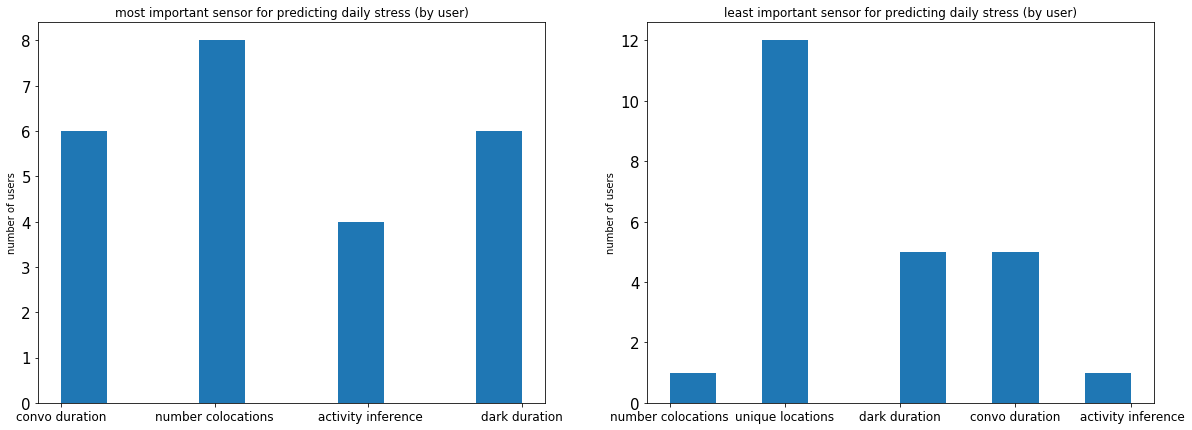

In [30]:
compiled_features = compile_clustering_features()

In [31]:
from sklearn.cluster import AgglomerativeClustering

def importance_clustering(compiled_features, n_clusters): 
    """
    inputs: compiled_features containing survey scores and sensor rankings. 
    
    this function performs agglomerative clustering with 4 groups. 
    """
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters)
    
    features = compiled_features[['pss score', 'loneliness score']].values
    
    clustering.fit(features)
    
    compiled_features['cluster'] = clustering.labels_
    
    return compiled_features

In [32]:
clusters = importance_clustering(compiled_features, 2)
#for i in clusters['cluster'].unique(): 
#    print(clusters[clusters['cluster'] == i])

In [33]:
clusters[clusters['cluster'] == 1]

,first,second,third,fourth,fifth,id,pss score,loneliness score,cluster
3,activity inference,unique locations,dark duration,number colocations,convo duration,u04,21.0,54,1
5,dark duration,activity inference,number colocations,convo duration,unique locations,u10,20.0,64,1
9,dark duration,activity inference,number colocations,unique locations,convo duration,u17,33.0,51,1
10,convo duration,dark duration,number colocations,activity inference,unique locations,u19,20.0,55,1
11,convo duration,dark duration,activity inference,number colocations,unique locations,u23,27.0,47,1
13,dark duration,number colocations,activity inference,convo duration,unique locations,u33,33.0,62,1
19,dark duration,activity inference,number colocations,unique locations,convo duration,u52,22.0,60,1
22,activity inference,number colocations,dark duration,convo duration,unique locations,u58,20.0,51,1


In [34]:
clusters[clusters['cluster'] == 0]

,first,second,third,fourth,fifth,id,pss score,loneliness score,cluster
0,convo duration,dark duration,activity inference,unique locations,number colocations,u00,24.0,32,0
1,number colocations,dark duration,activity inference,convo duration,unique locations,u01,15.0,31,0
2,activity inference,unique locations,convo duration,number colocations,dark duration,u02,21.0,32,0
4,number colocations,dark duration,unique locations,convo duration,activity inference,u08,23.0,34,0
6,number colocations,activity inference,unique locations,dark duration,convo duration,u12,11.0,44,0
7,activity inference,number colocations,convo duration,unique locations,dark duration,u14,9.0,29,0
8,convo duration,activity inference,number colocations,unique locations,dark duration,u16,24.0,35,0
12,number colocations,unique locations,convo duration,activity inference,dark duration,u32,3.0,28,0
14,dark duration,number colocations,activity inference,unique locations,convo duration,u36,12.0,34,0
15,number colocations,dark duration,activity inference,convo duration,unique locations,u43,21.0,40,0


In [35]:
plot_ranking_clusters(clustered_df): 
    """
    input: clustered_df containing rankings and clusters for each user id. 
    """
    
    for value in cluster.unique(): 
        

SyntaxError: invalid syntax (<ipython-input-35-b9a7d8522f11>, line 1)